# Notebook For EDA

In this notebook I extract and analyze some Naive Features and some Graph Level Features.


Further reading for me :

1. source code on the networkx Base Graph object
https://networkx.org/documentation/stable/_modules/networkx/classes/graph.html

2. Semi supervised learning for classification problems (on graphs)
https://github.com/RobRomijnders/ssl_graph


### Dependencies  

In [1]:
# %%capture 
# # %%capture cell magic  makes this cell silent. 

# # torch-geometric is an externsion of torch for working with graphs
# !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
# !pip install -q torch-geometric
# # pysmiles
# !pip install pysmiles

# # pyTDC is the Therapudic Data Commons my data source
# !pip install PyTDC
# !python -m pip install git+https://github.com/EBjerrum/molvecgen # unsure what this is.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tdc.single_pred import ADME

data = ADME(name = 'CYP2C9_Veith') # this is the binary molecule problem
df = data.get_data()
df = df[['Drug','Y']]
df['target'] = df['Y']
df = df[['Drug', 'target']]
df['target'].value_counts()

Downloading...
100%|██████████| 740k/740k [00:01<00:00, 598kiB/s] 
Loading...
Done!


0    8047
1    4045
Name: target, dtype: int64

In [6]:
mol_sizes  = df['Drug'].str.len()
mol_sizes.describe()

count    12092.000000
mean        46.381905
std         20.790554
min          2.000000
25%         35.000000
50%         43.000000
75%         52.000000
max        340.000000
Name: Drug, dtype: float64

In [7]:
df['mol_sizes'] = df['Drug'].str.len()
df.sort_values('mol_sizes')

,Drug,target,mol_sizes
5586,NO,0,2
5668,NCCS,0,4
5725,NCCCCN,0,6
5387,N#CCCN,0,6
5379,CC(N)=O,0,7
...,...,...,...
6169,CN[C@@H](CC(C)C)C(=O)N[C@@H]1C(=O)N[C@H](CC(N)...,0,266
6525,C/C=C(\C)C(=O)O.C/C=C(\C)C(=O)O.CO[C@@H]1CC[C@...,0,282
6165,C=C(NC(=O)C(=C)NC(=O)c1csc(C2=N[C@@H]3c4csc(n4...,0,301
7179,C[C@H](O)CO[C@@H]1[C@@H](O)[C@@H]2O[C@H]3O[C@H...,0,311


# Outline
Exploratory Data Analysis (EDA) is typically the start of any data science project. 
 
Some typical methods for “getting a feel” of your data are:
 
Create plots of different features
See the correlation between features. 
Visualize the variance and any unusual patterns between features. 
 
For Graph objects these normal techniques are difficult to apply since this is what my data looks like.
 
```
0             CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21
1                         Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1
2          COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1
3                     COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1
```
 
## Parts
1. A “naive” approach: look at simple correlations and summary stats on the symbols used in the smiles.
 
2. Look at simple graph level features.   
  Total and Average Degree,Total and Average Nodes, 
  


# Naive Approach



In [3]:
def split(word): 
    return [char for char in word]  

drugs = df['Drug'].values
drug_chars = [split(s) for s in drugs]
all_chars = list(itertools.chain(*drug_chars))
unique_chars = set(all_chars)
unique_chars = sorted(list(unique_chars))
unique_chars[:5] # this will be the vector

['#', '%', '(', ')', '+']

In [4]:
def compute_drug_char_value_counts(df, unique_chars=unique_chars)-> pd.DataFrame:
  """
      Takes in df and computes the value count of each symbol adding in 0s where they are not present. 
      Returns a dataframe of the count of occurances of each symbol.
      Takes ~16 min to run 
  """
  set_of_unique_symbols = set(unique_chars)
  df_with_drug_and_target = pd.DataFrame(columns=['Drug', *unique_chars, 'target'])

  for index in range(len(df)):
    drug_chars = split(df.loc[index,'Drug'])
    char_value_counts_df =  pd.DataFrame(drug_chars).value_counts()
    
    present_symbols = char_value_counts_df.index.values.tolist()
    present_symbols = set([a[0] for a in present_symbols])
    missing_symbols = list(set_of_unique_symbols - present_symbols)

    for symbol in missing_symbols:
      char_value_counts_df[symbol] = 0 # add 0 for the value counts into the df makes the output vector fixed size.

    char_value_counts_df.sort_index(inplace=True)
    ordered_value_counts = char_value_counts_df.values
    row = [df.loc[index,'Drug'], *ordered_value_counts, df.loc[index,'target']]
    df_with_drug_and_target.loc[index] = row

  return df_with_drug_and_target

compute_drug_char_value_counts(df.loc[:10])


,Drug,#,%,(,),+,-,.,/,0,1,2,3,4,5,6,7,8,9,=,@,A,B,C,F,H,I,K,L,M,N,O,P,S,W,Z,[,\,],a,b,c,e,g,i,l,n,o,r,s,t,u,target
0,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,0,0,4,4,0,0,0,1,0,2,4,0,0,0,0,0,0,0,4,0,0,0,11,0,0,0,0,0,0,2,3,0,2,0,0,0,1,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1
1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,0,0,1,1,0,2,0,0,0,4,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,14,0,0,0,1,3,0,0,0,0,0,1
2,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,0,0,4,4,0,0,0,0,0,6,2,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,12,0,0,0,0,5,0,0,0,0,0,1
3,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,0,0,2,2,0,1,0,0,0,4,2,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,12,0,0,0,0,5,0,0,0,0,0,1
4,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,0,0,3,3,0,0,0,0,0,8,2,0,0,0,0,0,0,0,1,0,0,0,16,0,1,0,0,0,0,2,3,0,0,0,0,1,0,1,0,0,10,0,0,0,0,5,0,0,0,0,0,0
5,Br.N=c1n(CCN2CCOCC2)c2ccccc2n1CC(=O)c1ccc(Cl)c...,0,0,4,4,0,0,1,0,0,4,4,0,0,0,0,0,0,0,2,0,0,1,10,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,13,0,0,0,2,2,0,1,0,0,0,1
6,COc1ccc(/C(O)=C2/C(=O)C(=O)N(CCCC(=O)O)C2c2ccc...,0,0,7,7,0,0,0,2,0,2,4,0,0,0,0,0,0,0,4,0,0,0,11,0,0,0,0,0,0,1,7,0,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0
7,CCC(C)(C)NC(=O)c1ccc2c(c1)N(CC(=O)OC)C(=O)C(C)...,0,0,9,9,0,0,0,0,0,2,2,0,0,0,0,0,0,0,3,0,0,0,13,0,0,0,0,0,0,2,5,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,1
8,COc1cccc2c(=O)c(C(=O)NCc3cccs3)c[nH]c12,0,0,3,3,0,0,0,0,0,2,2,2,0,0,0,0,0,0,2,0,0,0,3,0,1,0,0,0,0,1,3,0,0,0,0,1,0,1,0,0,13,0,0,0,0,1,0,0,1,0,0,1
9,CC(C)(C)NC(=O)CSc1nnc(Cc2ccc3c(c2)OCO3)n1C1CCCCC1,0,0,5,5,0,0,0,0,0,4,2,2,0,0,0,0,0,0,1,0,0,0,14,0,0,0,0,0,0,1,3,0,1,0,0,0,0,0,0,0,8,0,0,0,0,3,0,0,0,0,0,0


In [7]:
%%time
value_count_df = compute_drug_char_value_counts(df) # a little time intensive 

CPU times: user 15min 7s, sys: 17 s, total: 15min 24s
Wall time: 15min 3s


In [8]:
value_count_df.to_csv('full_value_counts_df.csv') # saved this in github

numeric_features = list(value_count_df.columns[1:-1])

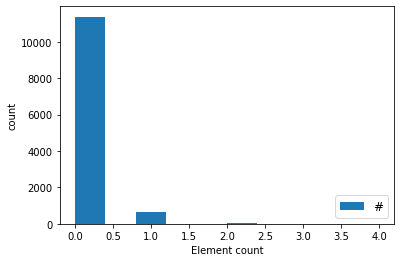

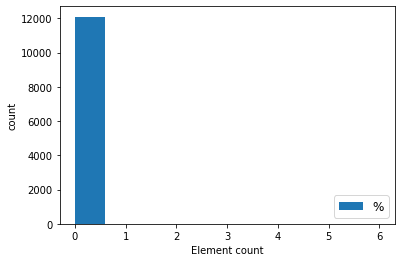

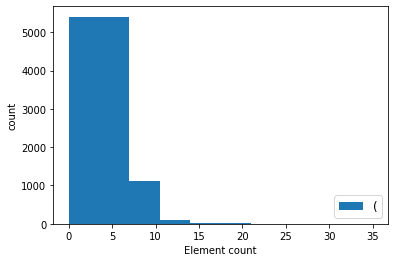

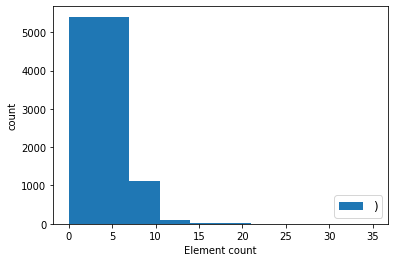

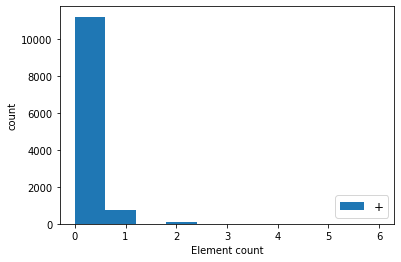

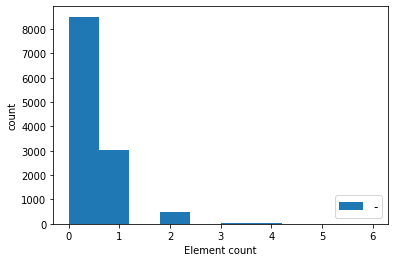

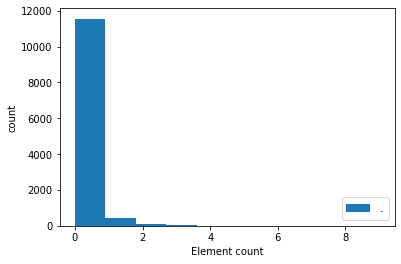

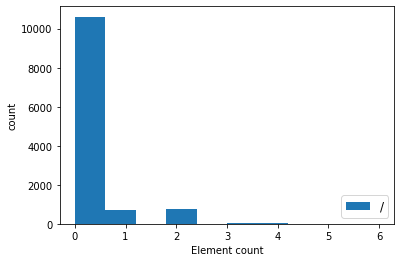

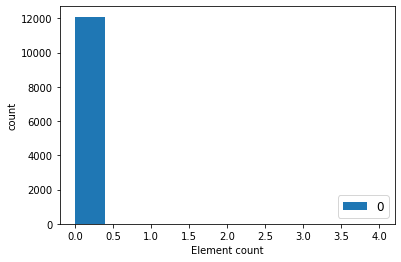

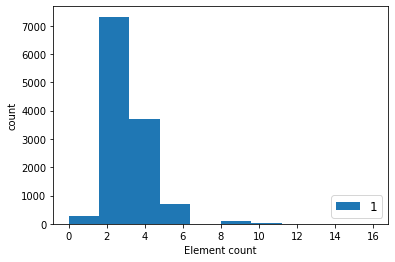

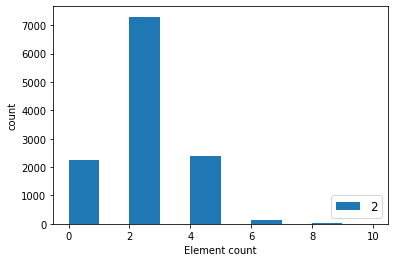

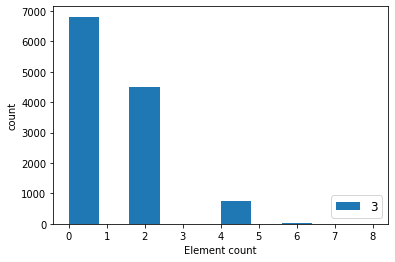

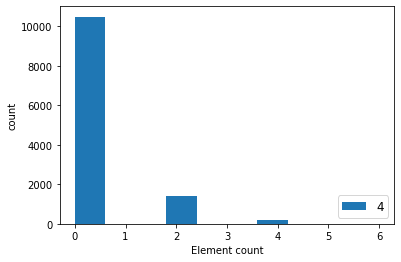

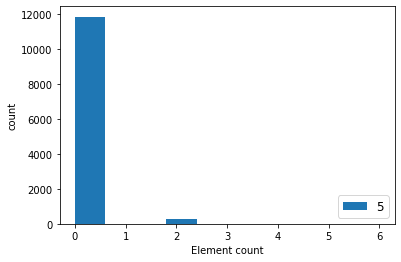

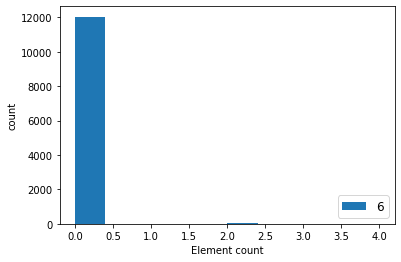

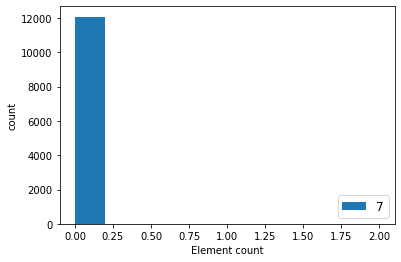

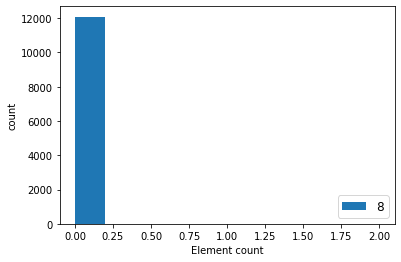

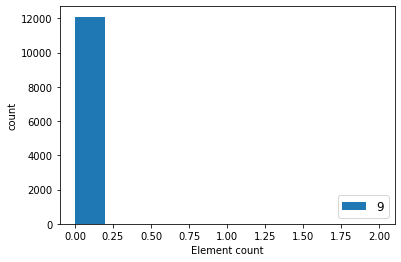

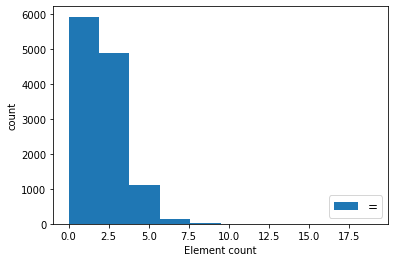

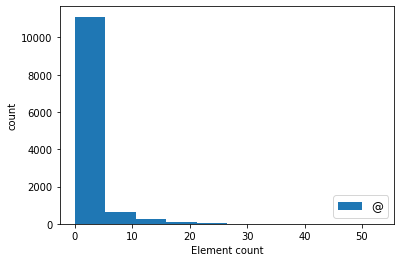

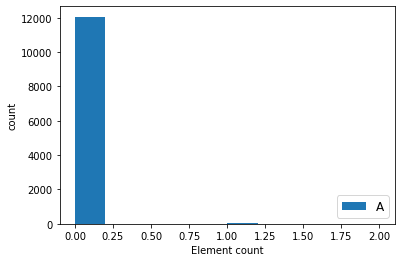

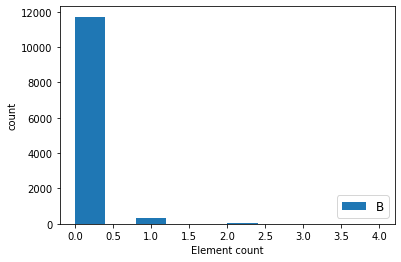

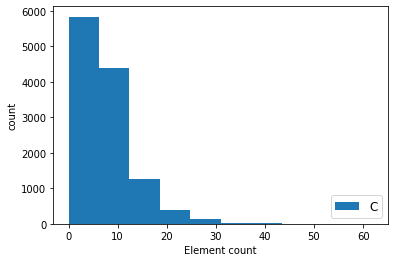

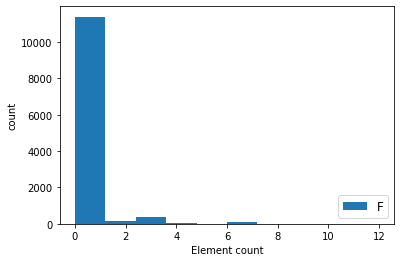

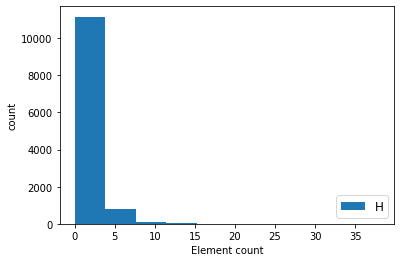

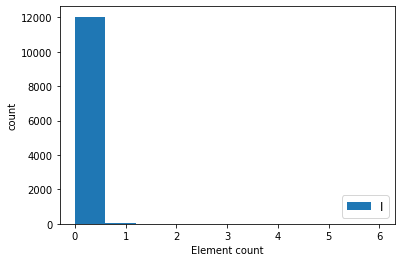

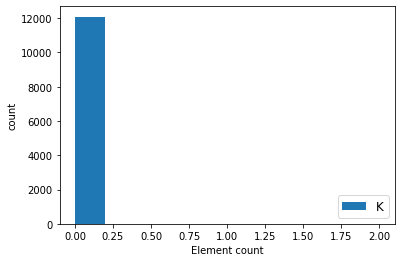

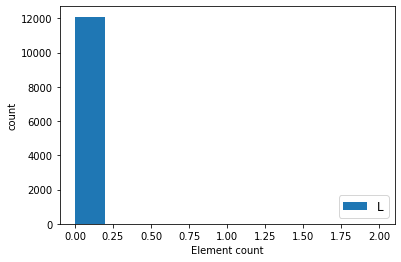

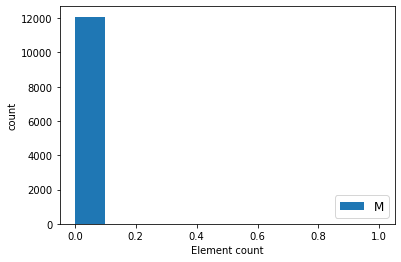

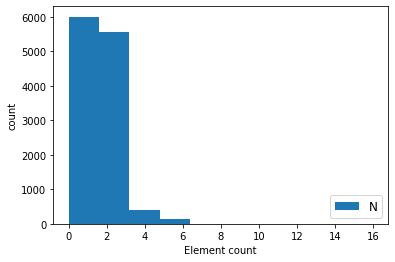

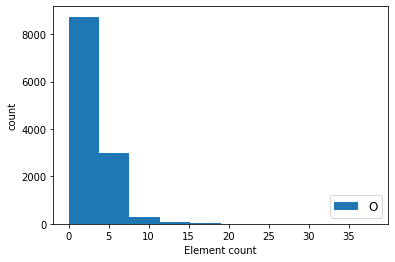

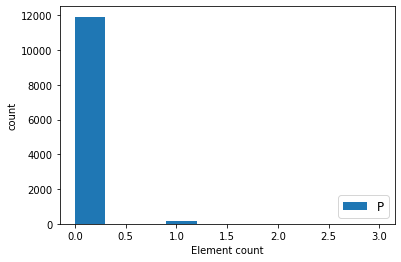

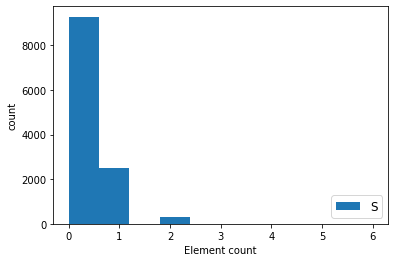

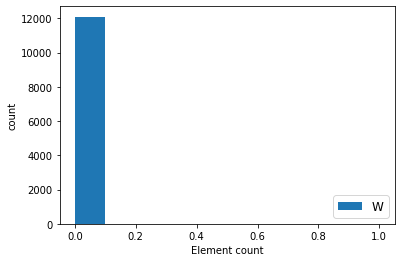

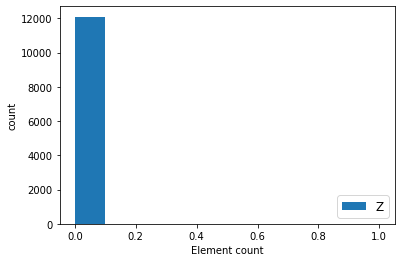

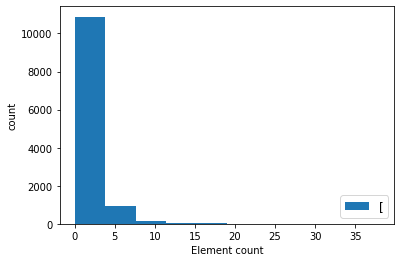

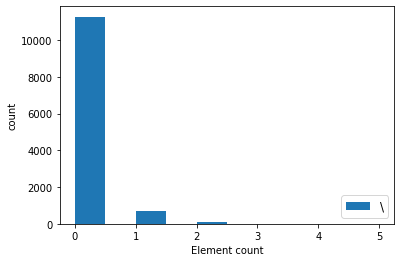

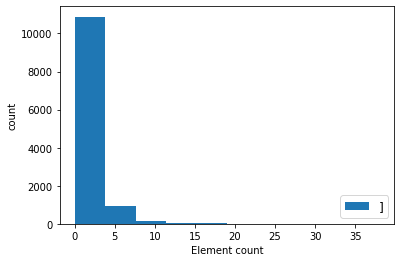

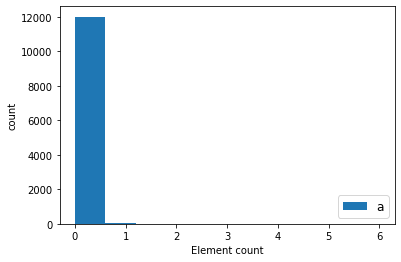

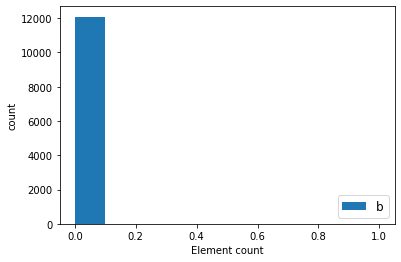

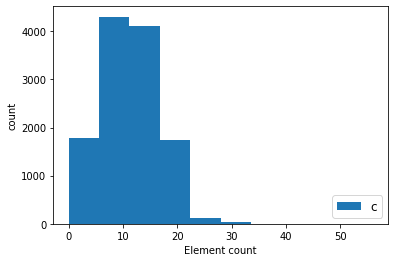

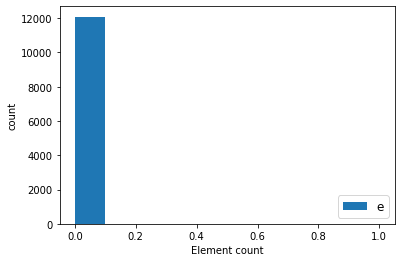

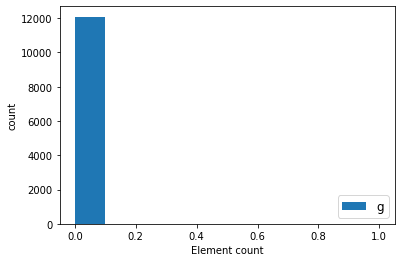

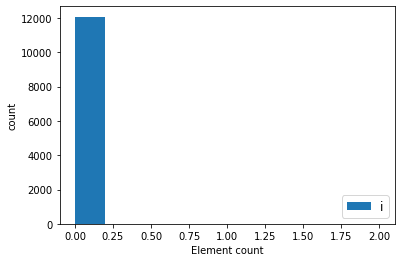

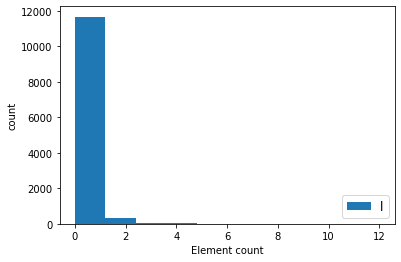

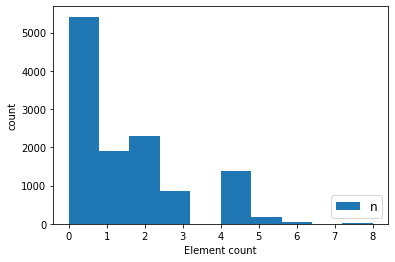

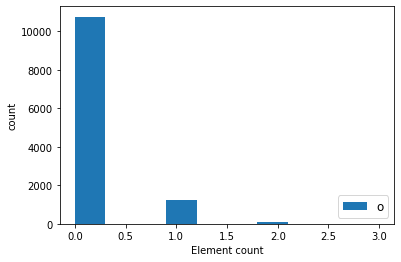

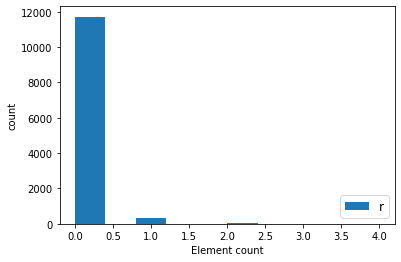

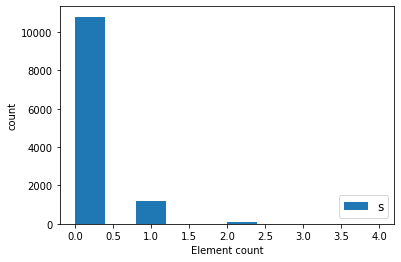

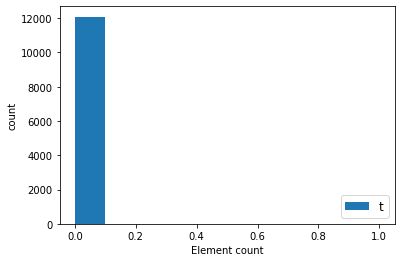

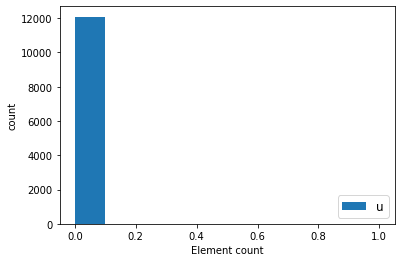

In [9]:


for feature in numeric_features:
  plt.hist(value_count_df[feature])
  plt.ylabel('count')
  plt.xlabel('Element count')
  plt.legend(feature, loc='lower right', fontsize='large')
  plt.show()

#### Box plots

#### Character-wise summary stats


In [ ]:
numeric_df = value_count_df[numeric_features]
descriptive_df = numeric_df.describe(datetime_is_numeric=True)
modes = numeric_df.mode(axis=0)
medians = numeric_df.median(axis=0)
means = numeric_df.mean(axis=0)

descriptive_df = descriptive_df.append(modes,ignore_index=True)
descriptive_df = descriptive_df.append(medians,ignore_index=True)
descriptive_df = descriptive_df.append(means,ignore_index=True)

descriptive_df.reset_index(level=0, inplace=True)

descriptive_df['index'] = ['count', 'unique', 'top','freq', 'mode', 'median', 'mean']
descriptive_df.set_index('index', inplace=True)
descriptive_df

In [12]:
# Letter repersent elements where the other symbols repersent the types of bonds
import regex as re
elements = [a for a in unique_chars if re.search('[a-zA-Z]', a)]
elements_df = value_count_df[elements].astype(int)
elements_df

,A,B,C,F,H,I,K,L,M,N,O,P,S,W,Z,a,b,c,e,g,i,l,n,o,r,s,t,u
0,0,0,11,0,0,0,0,0,0,2,3,0,2,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,1,3,0,0,0,0,0
2,0,0,11,0,0,0,0,0,0,2,1,0,0,0,0,0,0,12,0,0,0,0,5,0,0,0,0,0
3,0,0,4,0,0,0,0,0,0,1,2,0,0,0,0,0,0,12,0,0,0,0,5,0,0,0,0,0
4,0,0,16,0,1,0,0,0,0,2,3,0,0,0,0,0,0,10,0,0,0,0,5,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12087,0,0,14,0,5,0,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12088,0,0,11,0,3,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12089,0,0,16,0,6,0,0,0,0,1,6,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0
12090,0,0,14,0,7,0,0,0,0,1,5,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0


In [13]:
elements_df.corr()


,A,B,C,F,H,I,K,L,M,N,O,P,S,W,Z,a,b,c,e,g,i,l,n,o,r,s,t,u
A,1.000000,0.005148,-0.055923,-0.013078,-0.015750,0.007464,-0.001054,-0.000559,-0.000722,-0.004042,0.048669,-0.005161,-0.012489,-0.000417,-0.000589,-0.003134,-0.001179,-0.010663,-0.000722,-0.000833,-0.001516,-0.010749,-0.027164,-0.015640,0.005263,0.163305,-0.001179,-0.001103
B,0.005148,1.000000,-0.053563,-0.029914,-0.022250,-0.000784,-0.003820,-0.002025,-0.002615,-0.034579,-0.021899,0.014932,-0.017981,-0.001510,-0.002135,0.005939,-0.004271,0.004573,-0.002615,0.038756,-0.005495,-0.023822,-0.061839,0.011605,0.989480,0.001332,-0.004271,-0.003995
C,-0.055923,-0.053563,1.000000,0.004767,0.636441,0.002691,0.036237,-0.007727,0.003096,0.255993,0.528661,-0.023532,-0.075690,0.011491,-0.008908,0.015006,-0.011529,-0.359111,-0.010910,-0.010173,-0.002127,-0.039879,-0.337624,-0.096613,-0.052961,-0.104680,-0.006382,0.003508
F,-0.013078,-0.029914,0.004767,1.000000,-0.057574,-0.015368,-0.006569,-0.003483,-0.004497,-0.000619,-0.081864,-0.022048,-0.047780,-0.002596,-0.003672,-0.018118,-0.007345,0.074822,0.001394,-0.005193,-0.006974,-0.028948,0.016577,-0.037317,-0.031452,-0.026214,-0.007345,-0.006870
H,-0.015750,-0.022250,0.636441,-0.057574,1.000000,0.009675,0.049378,0.012070,0.012834,0.030172,0.621433,0.063847,-0.085410,0.020109,-0.005238,0.057914,0.009733,-0.250157,0.007334,0.014026,0.000387,-0.079603,-0.140811,-0.078300,-0.024024,-0.109220,0.008048,0.024408
I,0.007464,-0.000784,0.002691,-0.015368,0.009675,1.000000,-0.001239,-0.000657,-0.000848,0.027853,0.046573,-0.006064,-0.020445,-0.000490,-0.000692,-0.003682,-0.001385,-0.005790,-0.000848,-0.000979,-0.001782,-0.008815,-0.026248,-0.016635,-0.000709,-0.016205,-0.001385,-0.001296
K,-0.001054,-0.003820,0.036237,-0.006569,0.049378,-0.001239,1.000000,-0.000281,-0.000363,-0.021894,0.040631,-0.002592,0.032933,-0.000209,-0.000296,-0.001574,-0.000592,-0.032574,-0.000363,-0.000419,-0.000762,-0.007980,-0.018231,-0.007856,-0.003817,0.000743,-0.000592,-0.000554
L,-0.000559,-0.002025,-0.007727,-0.003483,0.012070,-0.000657,-0.000281,1.000000,-0.000192,-0.009827,0.028254,0.164827,-0.006194,-0.000111,-0.000157,-0.000835,-0.000314,-0.015755,-0.000192,-0.000222,0.542260,0.003295,0.010989,-0.004166,-0.002024,-0.004065,-0.000314,-0.000294
M,-0.000722,-0.002615,0.003096,-0.004497,0.012834,-0.000848,-0.000363,-0.000192,1.000000,-0.003482,0.048030,-0.001775,-0.007996,-0.000143,-0.000203,-0.001077,-0.000405,0.018370,-0.000248,-0.000287,-0.000521,-0.005463,0.003695,-0.005378,-0.002613,-0.005248,-0.000405,-0.000379
N,-0.004042,-0.034579,0.255993,-0.000619,0.030172,0.027853,-0.021894,-0.009827,-0.003482,1.000000,0.096454,-0.003012,0.105715,-0.004667,-0.006600,0.099648,-0.027299,-0.065701,0.005723,-0.009335,-0.024724,-0.035915,-0.240643,-0.038295,-0.032075,-0.010136,-0.001928,0.032851


#### Notes on the description of the value counts of features
 
1. The data is very sparse. The majority of symbols don't appear in any given drug. The mode frequency is 0, but based on the box plots you can see plenty of outliers. 
 
2. Some elements are very common and others are very rae. For example there are very many Carbon, Oxygen and Nitrogen Atoms  but very few Phosphorus or Tungsten Atoms. This makes sense because those elements are common in organic life. 

3. A single type of atom can be represented as upper or lower case based on certain chemical properties. This information is captured by the smiles library I am using. 
 


# Graph Level Features

1. Node Degree
2. Node Count
3. Loop characteristics 

This library loses "stereochemical information".

'''
Stereochemistry, a subdiscipline of chemistry, involves the study of the relative spatial arrangement of atoms that form the structure of molecules and their manipulation.[1] The study of stereochemistry focuses on stereoisomers, which by definition have the same molecular formula and sequence of bonded atoms (constitution), but differ in the three-dimensional orientations of their atoms in space. For this reason, it is also known as 3D chemistry—the prefix "stereo-" means "three-dimensionality
'''
source: https://en.wikipedia.org/wiki/Stereochemistry 

In layterms, it loses the 3d information of the molecules. This might be a problem I am not sure yet. For the model building I will use an Graph repersentation that also encodes 3d space information. I might be able to use this library https://docs.eyesopen.com/toolkits/python/oechemtk/stereochemistry.html 

For now I am going with pysmiles since it has all the characteristics I need.

E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded


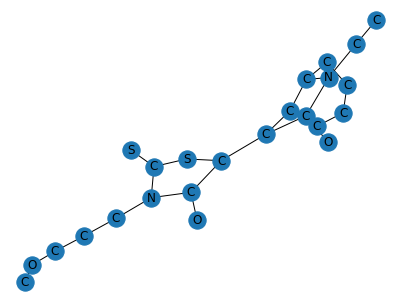

In [14]:
from pysmiles import read_smiles
import networkx as nx #  Graph representation library

mol = read_smiles(df['Drug'][0])
elements = nx.get_node_attributes(mol, name = "element")
nx.draw(mol, with_labels=True, labels = elements, pos=nx.spring_layout(mol))
plt.gca().set_aspect('equal')

In [15]:
# holds the graph repersentations of the molecules.
%%time
graph_object_df = pd.DataFrame()
graph_object_df['target'] = df['target']
graph_object_df['Drug'] = df['Drug']
graph_object_df['Graph'] = [read_smiles(s) for s in graph_object_df['Drug']]

Streaming output truncated to the last 5000 lines.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
Atom "[C@H]" contains stereochemical information that will be discarded.
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "\", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical information, which is specified by "/", will be discarded
E/Z stereochemical informatio

CPU times: user 45 s, sys: 3.94 s, total: 49 s
Wall time: 53.6 s


In [34]:
%%time
graph_object_df['Graph'] # this hold the grpah objects. 
graph_object_df['total_nodes'] = [len(mol.nodes) for mol in graph_object_df['Graph']]
graph_object_df['total_edges'] = [len(mol.edges) for mol in graph_object_df['Graph']]
graph_object_df['average_node_degree'] = graph_object_df['total_edges'] / graph_object_df['total_nodes'] # defined as ratio of edges:nodes
graph_object_df['average_shortest_path_length'] = [nx.average_shortest_path_length(mol) for mol in graph_object_df['Graph']] # time intensive

# https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.generic.average_shortest_path_length.html#networkx.algorithms.shortest_paths.generic.average_shortest_path_length

graph_object_df

CPU times: user 16.3 s, sys: 53.1 ms, total: 16.4 s
Wall time: 16.4 s


26


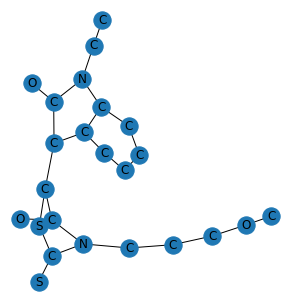

In [33]:
a= graph_object_df['Graph'][0]
print(len(a.edges))

elements = nx.get_node_attributes(a, name = "element")
nx.draw(mol, with_labels=True, labels = elements, pos=nx.spring_layout(mol))
plt.gca().set_aspect('equal')


## There are more graph level feature than I could reasonably look at.

I will just add some summary stats of the basis cycles. 



In [27]:
def compute_basis_cycle_stats(G: nx.Graph) -> dict:
  """
      Compute the basis cycles of G and some stats about their composition
      This is kind of like the prime factorization of a graph.
      Not optimized.

      I can get a bunch more features here but I think these are enough for now.
      
      See: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.cycle_basis.html#networkx.algorithms.cycles.cycle_basis
  """
  basis_cycles = nx.cycle_basis(G)
  num_basis_cycles = len(basis_cycles)
  nodes_in_cycle = set()
  for cycle in basis_cycles:
    for node in cycle:
      nodes_in_cycle.add(node)

  num_nodes_in_cycle = len(nodes_in_cycle)
  num_nodes_outside_of_cycle = len(G.nodes) - num_nodes_in_cycle
  average_cycle_size = 0

  for cycle in basis_cycles: 
    average_cycle_size += len(cycle)
  try:
    average_cycle_size = average_cycle_size / len(basis_cycles)
  except ZeroDivisionError :
    average_cycle_size = 0

  ret = dict()
  ret['basis_cycles'] = basis_cycles
  ret['num_basis_cycles'] = num_basis_cycles
  ret['nodes_in_cycles'] = nodes_in_cycle
  ret['num_nodes_in_cycle'] = num_nodes_in_cycle
  ret['num_nodes_outside_of_cycle'] = num_nodes_outside_of_cycle
  ret['average_cycle_size'] = average_cycle_size

  return ret

compute_basis_cycle_stats(a)

{'average_cycle_size': 5.333333333333333,
 'basis_cycles': [[22, 21, 20, 19, 18, 23],
  [3, 5, 18, 23, 2],
  [7, 8, 10, 16, 6]],
 'nodes_in_cycles': {2, 3, 5, 6, 7, 8, 10, 16, 18, 19, 20, 21, 22, 23},
 'num_basis_cycles': 3,
 'num_nodes_in_cycle': 14,
 'num_nodes_outside_of_cycle': 10}

In [28]:
basis_cycle_stats_list = [compute_basis_cycle_stats(mol) for mol in graph_object_df['Graph']]

basis_cycle_stats_df = pd.DataFrame(basis_cycle_stats_list)

In [29]:

basis_cycle_stats_df

,basis_cycles,num_basis_cycles,nodes_in_cycles,num_nodes_in_cycle,num_nodes_outside_of_cycle,average_cycle_size
0,"[[22, 21, 20, 19, 18, 23], [3, 5, 18, 23, 2], ...",3,"{2, 3, 5, 6, 7, 8, 10, 16, 18, 19, 20, 21, 22,...",14,10,5.333333
1,"[[8, 9, 16, 17, 7], [11, 12, 13, 14, 15, 10], ...",3,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",17,1,5.666667
2,"[[24, 25, 26, 27, 28, 23], [19, 20, 21, 29, 30...",4,"{2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 18, 19, ...",23,8,5.750000
3,"[[18, 19, 20, 21, 22, 17], [14, 15, 16, 23, 13...",3,"{2, 3, 4, 5, 6, 7, 13, 14, 15, 16, 17, 18, 19,...",17,7,5.666667
4,"[[25, 26, 32, 33, 34, 24], [31, 30, 28, 27, 26...",5,"{3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 17, 18, 19,...",26,10,5.600000
...,...,...,...,...,...,...
12087,"[[5, 16, 9, 8, 7, 6], [10, 12, 13, 14, 16, 9],...",3,"{2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17}",13,6,5.666667
12088,"[[10, 11, 12, 13, 14, 9], [7, 6, 8], [3, 4, 6,...",3,"{2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14}",12,3,5.000000
12089,"[[24, 25, 26, 27, 28, 23], [2, 18, 19, 21, 1],...",6,"{1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...",25,4,5.333333
12090,"[[11, 23, 15, 14, 13, 12], [16, 18, 19, 21, 23...",4,"{2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...",19,7,5.750000


In [30]:
full_graph_level_features_df = graph_object_df.join(basis_cycle_stats_df)

full_graph_level_features_df

,target,Drug,Graph,total_nodes,total_edges,average_node_degree,average_shortest_path_length,basis_cycles,num_basis_cycles,nodes_in_cycles,num_nodes_in_cycle,num_nodes_outside_of_cycle,average_cycle_size
0,1,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",24,26,1.083333,4.692029,"[[22, 21, 20, 19, 18, 23], [3, 5, 18, 23, 2], ...",3,"{2, 3, 5, 6, 7, 8, 10, 16, 18, 19, 20, 21, 22,...",14,10,5.333333
1,1,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",18,20,1.111111,4.078431,"[[8, 9, 16, 17, 7], [11, 12, 13, 14, 15, 10], ...",3,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",17,1,5.666667
2,1,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",31,34,1.096774,5.718280,"[[24, 25, 26, 27, 28, 23], [19, 20, 21, 29, 30...",4,"{2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 18, 19, ...",23,8,5.750000
3,1,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",24,26,1.083333,5.735507,"[[18, 19, 20, 21, 22, 17], [14, 15, 16, 23, 13...",3,"{2, 3, 4, 5, 6, 7, 13, 14, 15, 16, 17, 18, 19,...",17,7,5.666667
4,0,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",36,40,1.111111,6.377778,"[[25, 26, 32, 33, 34, 24], [31, 30, 28, 27, 26...",5,"{3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 17, 18, 19,...",26,10,5.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12087,0,CCN1C(=O)[C@@H]2[C@@H](CC[C@@H]3C(=O)C=C[C@@H]...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",19,21,1.105263,3.526316,"[[5, 16, 9, 8, 7, 6], [10, 12, 13, 14, 16, 9],...",3,"{2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 16, 17}",13,6,5.666667
12088,0,C=CC1=C[C@@H](O)[C@@H]2O[C@@H]2C12OCCCO2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",15,17,1.133333,3.047619,"[[10, 11, 12, 13, 14, 9], [7, 6, 8], [3, 4, 6,...",3,"{2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14}",12,3,5.000000
12089,0,O=C1[C@H]2CC=C3[C@@H]([C@H](O)[C@H]4O[C@@H]4C3...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",29,34,1.172414,4.970443,"[[24, 25, 26, 27, 28, 23], [2, 18, 19, 21, 1],...",6,"{1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 1...",25,4,5.333333
12090,0,C[C@H](c1ccccc1)N1C(=O)[C@@H]2[C@@H](CC[C@@H]3...,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",26,29,1.115385,4.606154,"[[11, 23, 15, 14, 13, 12], [16, 18, 19, 21, 23...",4,"{2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...",19,7,5.750000


In [31]:
full_graph_level_features_df.columns

Index(['target', 'Drug', 'Graph', 'total_nodes', 'total_edges',
       'average_node_degree', 'average_shortest_path_length', 'basis_cycles',
       'num_basis_cycles', 'nodes_in_cycles', 'num_nodes_in_cycle',
       'num_nodes_outside_of_cycle', 'average_cycle_size'],
      dtype='object')

#### Extract the numeric features of the graphs

In [23]:
numeric_graph_level_features = full_graph_level_features_df[['target', 'total_nodes', 'total_edges',
                        'average_node_degree', 'average_shortest_path_length',
                        'num_basis_cycles', 'num_nodes_in_cycle',
                        'num_nodes_outside_of_cycle', 'average_cycle_size']]

numeric_graph_level_features

,target,total_nodes,total_edges,average_node_degree,average_shortest_path_length,num_basis_cycles,num_nodes_in_cycle,num_nodes_outside_of_cycle,average_cycle_size
0,1,24,26,1.083333,4.692029,3,14,10,5.333333
1,1,18,20,1.111111,4.078431,3,17,1,5.666667
2,1,31,34,1.096774,5.718280,4,23,8,5.750000
3,1,24,26,1.083333,5.735507,3,17,7,5.666667
4,0,36,40,1.111111,6.377778,5,26,10,5.600000
...,...,...,...,...,...,...,...,...,...
12087,0,19,21,1.105263,3.526316,3,13,6,5.666667
12088,0,15,17,1.133333,3.047619,3,12,3,5.000000
12089,0,29,34,1.172414,4.970443,6,25,4,5.333333
12090,0,26,29,1.115385,4.606154,4,19,7,5.750000


In [24]:
numeric_graph_level_features.describe()

,target,total_nodes,total_edges,average_node_degree,average_shortest_path_length,num_basis_cycles,num_nodes_in_cycle,num_nodes_outside_of_cycle,average_cycle_size
count,12092.000000,12092.000000,12092.000000,12092.000000,12092.000000,12092.000000,12092.000000,12092.000000,12092.000000
mean,0.334519,25.028697,27.176728,1.079684,5.184657,3.148032,16.613960,8.414737,5.712772
std,0.471841,7.787970,8.837553,0.046809,1.204760,1.359924,6.651366,4.738214,1.271863
min,0.000000,2.000000,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,22.000000,1.055556,4.416667,2.000000,12.000000,5.000000,5.500000
50%,0.000000,24.000000,27.000000,1.086957,5.130435,3.000000,17.000000,8.000000,5.750000
75%,1.000000,29.000000,32.000000,1.111111,5.886774,4.000000,21.000000,11.000000,6.000000
max,1.000000,114.000000,123.000000,1.244898,16.435169,15.000000,69.000000,59.000000,33.000000


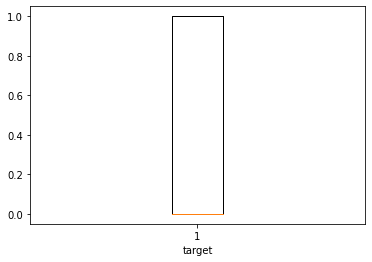

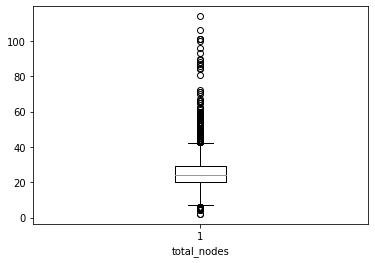

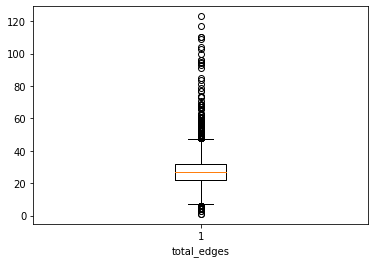

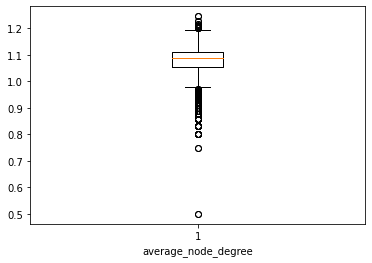

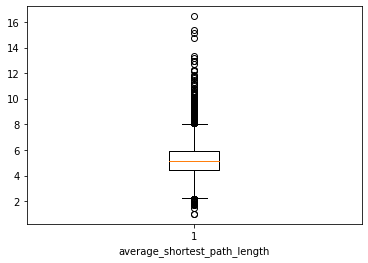

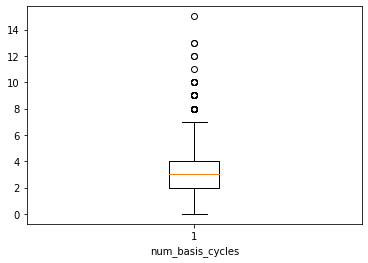

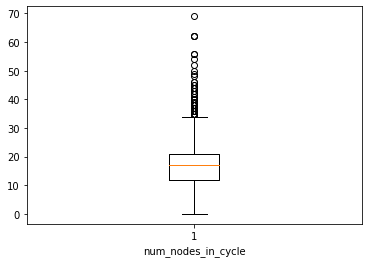

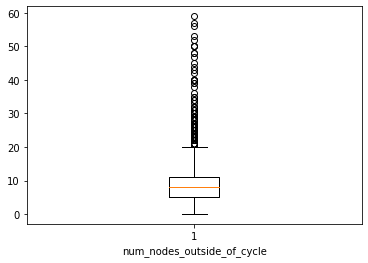

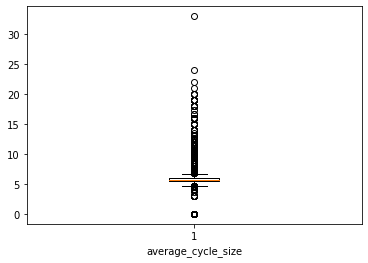

In [32]:

for feat in numeric_graph_level_features.columns:
  plt.boxplot(numeric_graph_level_features[feat])
  plt.xlabel(feat)
  plt.show()


## Conclusions. 
 
1. There are some attributes that are very common, such as Carbon and Oxygen while other elements that are very rare. This makes encoding each element counts as vectors problematic since the data would be very sparse.
 
2. Each molecule typically has 3 basis loops but there are outliers. 
 
3. Almost no features are normally distributed.
 
4. Most of the feature are characterized by a overwhelming majority of 0s and a few outliers with 1 or 2 elements of those count.s
 
5. `pysmiles` loses the 3d information of molecule orientation when it converts a SMILE into a graph. 
 
6. A molecule is a connected and undirected graph, there are more than one bond type, and there 20 node types. Most graph embedding algorithms that I found "off the shelf" don't work well with heterogenous node and link types.
 
7. The data is unbalanced where 2/3 are positive and 1/3 are negative. Due to the nature of the problem where a false negative is much worse than a false positive.
 
  [“The CYP P450 genes are essential in the breakdown (metabolism) of various molecules and chemicals within cells. A drug that can inhibit these enzymes would mean poor metabolism to this drug and other drugs, which could lead to drug-drug interactions and adverse effects”](https://tdcommons.ai/single_pred_tasks/adme/#cyp-p450-2c9-inhibition-veith-et-al)
 
 
8. I've been recommended by the chemists I've been talking to avoid focusing on manually extracting features like I did in this notebook but instead try a variety of different encoder-decoder schemes. 
